# Libraries

In [1]:
import os
import time
from datetime import datetime
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts, MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from models.wideresnet import WideResNet
from utils import *

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

# Configuration

In [3]:
class CFG:
    debug = False
    num_workers = 4
    batch_size = 128
    epochs = 200
    lr = 0.1
    weight_decay = 5e-4
    seed = 42
    
    #Multistep Scheduler
    milestones = [60, 120, 160]
    gamma = 0.2
    
    #LOGS
    LOGS_DIR = './logs'
    log_file = "wideresnet-16-1.log"

# Utilities

In [4]:
def init_logger(log_file=os.path.join(CFG.LOGS_DIR, datetime.now().strftime("%d-%m-%Y %H:%M:%S"))):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

if CFG.debug:
    LOGGER = init_logger('debug.log')
else:
    LOGGER = init_logger(os.path.join(CFG.LOGS_DIR, CFG.log_file))

In [5]:
datetime.now().strftime("%d-%m-%Y %H:%M:%S")

'23-06-2022 07:04:54'

In [6]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(CFG.seed)

# Dataset

In [7]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
BASE_DIR = "cifar-10-batches-py"

In [9]:
data = np.empty((0, 3072))
labels = []
for i in range(1,6):
    path = os.path.join(BASE_DIR, f"data_batch_{i}")
    dict = unpickle(path)
    data = np.vstack((data, dict[b'data']))
    labels.extend(dict[b'labels'])

In [10]:
train_data, valid_data, train_labels, valid_labels = train_test_split(data, labels, test_size=0.1, random_state=CFG.seed)

In [11]:
class CifarDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = np.transpose(data.reshape(data.shape[0], 3, 32, 32), (0, 2, 3, 1))/255
        
        self.labels = np.array(labels)
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if self.transform:
            image = self.transform(self.data[idx])
        else:
            image = torch.tensor(self.data[idx])
        label = torch.tensor(self.labels[idx])
        return image, label

In [12]:
transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Pad(4, padding_mode='reflect'),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomCrop(32),
                    
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                ]
            )

In [13]:
train_dataset = CifarDataset(train_data, train_labels, transform_train)
valid_dataset = CifarDataset(valid_data, valid_labels, transform_test)

In [14]:
def show_img(x):
    img, label = x
    print(label)
    plt.imshow(torch.permute(img, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(6)


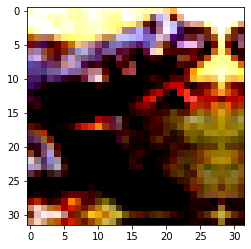

In [15]:
show_img(train_dataset[90])

In [16]:
path = os.path.join(BASE_DIR, f"test_batch")
dict = unpickle(path)
data = dict[b'data']
labels = dict[b'labels']

In [17]:
test_dataset = CifarDataset(data, labels, transform_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

# Model

In [19]:
model = WideResNet(16, 10, 1)
model.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(

# Helper Functions

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

In [21]:
def train_fn(train_loader, model, criterion, optimizer, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train()
    start = end = time.time()
    for step, (images, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        logits, features = model(images)
        loss = criterion(logits[0], labels)
        losses.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        batch_time.update(time.time() - end)
        end = time.time()

    return losses.avg


In [22]:
def valid_fn(test_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.eval()
    start = end = time.time()
    preds = []
    valid_labels = []
    for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):
        data_time.update(time.time() - end)
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            logits, features = model(images)
        loss = criterion(logits[0], labels)
        losses.update(loss.item(), batch_size)

        preds.append(logits[0].softmax(1).to('cpu').numpy())
        valid_labels.append(labels.to('cpu').numpy())
        
        batch_time.update(time.time() - end)
        end = time.time()

    predictions = np.concatenate(preds)
    valid_labels = np.concatenate(valid_labels)
    
    score = get_score(valid_labels, predictions.argmax(1))
    
    return losses.avg, score

# Training

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, momentum=0.9, nesterov=True)
scheduler = MultiStepLR(optimizer, milestones=CFG.milestones, gamma=CFG.gamma, verbose=False)

In [24]:
best_score = 0
training_logs = {'train_loss':[], 'valid_loss':[], 'accuracy':[]}

for epoch in range(CFG.epochs):
    
    start_time = time.time()
    
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)
    avg_val_loss, score = valid_fn(valid_loader, model, criterion, device)
    
    scheduler.step()
    
    training_logs['train_loss'].append(avg_loss)
    training_logs['valid_loss'].append(avg_val_loss)
    training_logs['accuracy'].append(score)
    
    LOGGER.info(f"Epoch {epoch+1}")
    LOGGER.info(f"Accuracy: {score:.4f} | Train loss: {avg_loss:.4f} | Valid loss: {avg_val_loss:.4f}")
    
    if score > best_score:
        print("YES")
        best_score = score
        print(f'Save Best Score: {best_score:.4f} Model')
        torch.save(model.state_dict(), f"best_model_wrn16-1.pt")
        
    elapsed = time.time() - start_time

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.83it/s]
Epoch 1
Accuracy: 0.5946 | Train loss: 1.4604 | Valid loss: 1.1190


YES
Save Best Score: 0.5946 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.48it/s]
Epoch 2
Accuracy: 0.6298 | Train loss: 1.0136 | Valid loss: 1.0520


YES
Save Best Score: 0.6298 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 77.06it/s]
Epoch 3
Accuracy: 0.6702 | Train loss: 0.8590 | Valid loss: 0.9856


YES
Save Best Score: 0.6702 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.89it/s]
Epoch 4
Accuracy: 0.6890 | Train loss: 0.7556 | Valid loss: 0.9291


YES
Save Best Score: 0.6890 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.66it/s]
Epoch 5
Accuracy: 0.7500 | Train loss: 0.6962 | Valid loss: 0.7260


YES
Save Best Score: 0.7500 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.30it/s]
Epoch 6
Accuracy: 0.6950 | Train loss: 0.6603 | Valid loss: 0.9169
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 72.11it/s]
Epoch 7
Accuracy: 0.7504 | Train loss: 0.6275 | Valid loss: 0.7406


YES
Save Best Score: 0.7504 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.58it/s]
Epoch 8
Accuracy: 0.7500 | Train loss: 0.6094 | Valid loss: 0.7467
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.05it/s]
Epoch 9
Accuracy: 0.7412 | Train loss: 0.5905 | Valid loss: 0.7727
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.67it/s]
Epoch 10
Accuracy: 0.7416 | Train loss: 0.5753 | Valid loss: 0.7526
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.19it/s]
Epoch 11
Accuracy: 0.7748 | Train loss: 0.5622 | Valid loss: 0.6637


YES
Save Best Score: 0.7748 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.88it/s]
Epoch 12
Accuracy: 0.7506 | Train loss: 0.5576 | Valid loss: 0.7838
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.10it/s]
Epoch 13
Accuracy: 0.7022 | Train loss: 0.5395 | Valid loss: 0.9709
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.25it/s]
Epoch 14
Accuracy: 0.7952 | Train loss: 0.5395 | Valid loss: 0.6291


YES
Save Best Score: 0.7952 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 82.76it/s]
Epoch 15
Accuracy: 0.7656 | Train loss: 0.5293 | Valid loss: 0.7064
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.98it/s]
Epoch 16
Accuracy: 0.7832 | Train loss: 0.5223 | Valid loss: 0.6509
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.19it/s]
Epoch 17
Accuracy: 0.7696 | Train loss: 0.5181 | Valid loss: 0.7005
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.20it/s]
Epoch 18
Accuracy: 0.7440 | Train loss: 0.5163 | Valid loss: 0.7548
100%|███████████████████████████████████████████████████████████████████████████████████████████████

YES
Save Best Score: 0.7956 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.58it/s]
Epoch 23
Accuracy: 0.8118 | Train loss: 0.4964 | Valid loss: 0.5522


YES
Save Best Score: 0.8118 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.74it/s]
Epoch 24
Accuracy: 0.7458 | Train loss: 0.4957 | Valid loss: 0.7434
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.65it/s]
Epoch 25
Accuracy: 0.7492 | Train loss: 0.4914 | Valid loss: 0.7575
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.92it/s]
Epoch 26
Accuracy: 0.7744 | Train loss: 0.4951 | Valid loss: 0.6598
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.57it/s]
Epoch 27
Accuracy: 0.7608 | Train loss: 0.4891 | Valid loss: 0.7444
100%|███████████████████████████████████████████████████████████████████████████████████████████████

YES
Save Best Score: 0.8212 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.80it/s]
Epoch 33
Accuracy: 0.7774 | Train loss: 0.4750 | Valid loss: 0.6609
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.86it/s]
Epoch 34
Accuracy: 0.8280 | Train loss: 0.4746 | Valid loss: 0.5087


YES
Save Best Score: 0.8280 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.66it/s]
Epoch 35
Accuracy: 0.7434 | Train loss: 0.4738 | Valid loss: 0.7833
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 62.32it/s]
Epoch 36
Accuracy: 0.8052 | Train loss: 0.4760 | Valid loss: 0.5533
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.06it/s]
Epoch 37
Accuracy: 0.7806 | Train loss: 0.4671 | Valid loss: 0.6746
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.22it/s]
Epoch 38
Accuracy: 0.8208 | Train loss: 0.4666 | Valid loss: 0.5340
100%|███████████████████████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 78.50it/s]
Epoch 56
Accuracy: 0.8010 | Train loss: 0.4549 | Valid loss: 0.5916
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 62.60it/s]
Epoch 57
Accuracy: 0.7914 | Train loss: 0.4519 | Valid loss: 0.6040
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.54it/s]
Epoch 58
Accuracy: 0.8412 | Train loss: 0.4489 | Valid loss: 0.4618


YES
Save Best Score: 0.8412 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 60.61it/s]
Epoch 59
Accuracy: 0.7540 | Train loss: 0.4505 | Valid loss: 0.7802
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.86it/s]
Epoch 60
Accuracy: 0.7982 | Train loss: 0.4471 | Valid loss: 0.5910
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 76.76it/s]
Epoch 61
Accuracy: 0.8896 | Train loss: 0.3157 | Valid loss: 0.3214


YES
Save Best Score: 0.8896 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.92it/s]
Epoch 62
Accuracy: 0.8932 | Train loss: 0.2788 | Valid loss: 0.3067


YES
Save Best Score: 0.8932 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 72.01it/s]
Epoch 63
Accuracy: 0.8918 | Train loss: 0.2659 | Valid loss: 0.3110
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.71it/s]
Epoch 64
Accuracy: 0.8894 | Train loss: 0.2596 | Valid loss: 0.3290
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.70it/s]
Epoch 65
Accuracy: 0.8876 | Train loss: 0.2554 | Valid loss: 0.3267
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.56it/s]
Epoch 66
Accuracy: 0.8950 | Train loss: 0.2528 | Valid loss: 0.3110


YES
Save Best Score: 0.8950 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.42it/s]
Epoch 67
Accuracy: 0.8916 | Train loss: 0.2515 | Valid loss: 0.3187
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 62.47it/s]
Epoch 68
Accuracy: 0.8786 | Train loss: 0.2539 | Valid loss: 0.3500
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.18it/s]
Epoch 69
Accuracy: 0.8936 | Train loss: 0.2543 | Valid loss: 0.3156
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.50it/s]
Epoch 70
Accuracy: 0.8868 | Train loss: 0.2526 | Valid loss: 0.3413
100%|███████████████████████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.31it/s]
Epoch 88
Accuracy: 0.8832 | Train loss: 0.2528 | Valid loss: 0.3588
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.06it/s]
Epoch 89
Accuracy: 0.8834 | Train loss: 0.2486 | Valid loss: 0.3675
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.39it/s]
Epoch 90
Accuracy: 0.8496 | Train loss: 0.2521 | Valid loss: 0.4683
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.54it/s]
Epoch 91
Accuracy: 0.8828 | Train loss: 0.2523 | Valid loss: 0.3486
100%|███████████████████████████████████████████████████████████████████████████████████████████████

Accuracy: 0.8648 | Train loss: 0.2485 | Valid loss: 0.4028
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.80it/s]
Epoch 110
Accuracy: 0.8854 | Train loss: 0.2402 | Valid loss: 0.3396
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.72it/s]
Epoch 111
Accuracy: 0.8626 | Train loss: 0.2429 | Valid loss: 0.4302
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.73it/s]
Epoch 112
Accuracy: 0.8660 | Train loss: 0.2419 | Valid loss: 0.4164
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.59it/s]
Epoch 113
Accuracy: 0.8828 | Train loss: 0.2435 | Valid loss: 0.3706
100%|████████████████████████████████

YES
Save Best Score: 0.9110 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.86it/s]
Epoch 122
Accuracy: 0.9116 | Train loss: 0.1462 | Valid loss: 0.2596


YES
Save Best Score: 0.9116 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.42it/s]
Epoch 123
Accuracy: 0.9148 | Train loss: 0.1358 | Valid loss: 0.2538


YES
Save Best Score: 0.9148 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.77it/s]
Epoch 124
Accuracy: 0.9166 | Train loss: 0.1330 | Valid loss: 0.2514


YES
Save Best Score: 0.9166 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.33it/s]
Epoch 125
Accuracy: 0.9176 | Train loss: 0.1284 | Valid loss: 0.2498


YES
Save Best Score: 0.9176 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.20it/s]
Epoch 126
Accuracy: 0.9128 | Train loss: 0.1254 | Valid loss: 0.2554
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.65it/s]
Epoch 127
Accuracy: 0.9168 | Train loss: 0.1244 | Valid loss: 0.2519
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.51it/s]
Epoch 128
Accuracy: 0.9200 | Train loss: 0.1195 | Valid loss: 0.2517


YES
Save Best Score: 0.9200 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.09it/s]
Epoch 129
Accuracy: 0.9156 | Train loss: 0.1148 | Valid loss: 0.2576
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 74.67it/s]
Epoch 130
Accuracy: 0.9158 | Train loss: 0.1124 | Valid loss: 0.2703
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.27it/s]
Epoch 131
Accuracy: 0.9150 | Train loss: 0.1151 | Valid loss: 0.2581
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.42it/s]
Epoch 132
Accuracy: 0.9164 | Train loss: 0.1124 | Valid loss: 0.2568
100%|███████████████████████████████████████████████████████████████████████████████████████████

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 76.96it/s]
Epoch 150
Accuracy: 0.9176 | Train loss: 0.0993 | Valid loss: 0.2705
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 76.81it/s]
Epoch 151
Accuracy: 0.9068 | Train loss: 0.0985 | Valid loss: 0.3059
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.65it/s]
Epoch 152
Accuracy: 0.9104 | Train loss: 0.1007 | Valid loss: 0.2958
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.93it/s]
Epoch 153
Accuracy: 0.9148 | Train loss: 0.0989 | Valid loss: 0.2853
100%|███████████████████████████████████████████████████████████████████████████████████████████

YES
Save Best Score: 0.9208 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.21it/s]
Epoch 162
Accuracy: 0.9206 | Train loss: 0.0726 | Valid loss: 0.2588
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.46it/s]
Epoch 163
Accuracy: 0.9224 | Train loss: 0.0699 | Valid loss: 0.2577


YES
Save Best Score: 0.9224 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.67it/s]
Epoch 164
Accuracy: 0.9220 | Train loss: 0.0681 | Valid loss: 0.2555
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.12it/s]
Epoch 165
Accuracy: 0.9206 | Train loss: 0.0657 | Valid loss: 0.2614
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 80.55it/s]
Epoch 166
Accuracy: 0.9226 | Train loss: 0.0616 | Valid loss: 0.2568


YES
Save Best Score: 0.9226 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 70.20it/s]
Epoch 167
Accuracy: 0.9200 | Train loss: 0.0639 | Valid loss: 0.2606
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.49it/s]
Epoch 168
Accuracy: 0.9202 | Train loss: 0.0648 | Valid loss: 0.2651
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.03it/s]
Epoch 169
Accuracy: 0.9200 | Train loss: 0.0649 | Valid loss: 0.2620
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 73.16it/s]
Epoch 170
Accuracy: 0.9200 | Train loss: 0.0607 | Valid loss: 0.2612
100%|███████████████████████████████████████████████████████████████████████████████████████████

YES
Save Best Score: 0.9228 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 68.06it/s]
Epoch 176
Accuracy: 0.9232 | Train loss: 0.0575 | Valid loss: 0.2635


YES
Save Best Score: 0.9232 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 84.19it/s]
Epoch 177
Accuracy: 0.9206 | Train loss: 0.0583 | Valid loss: 0.2624
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.68it/s]
Epoch 178
Accuracy: 0.9202 | Train loss: 0.0603 | Valid loss: 0.2685
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 83.22it/s]
Epoch 179
Accuracy: 0.9200 | Train loss: 0.0562 | Valid loss: 0.2660
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.72it/s]
Epoch 180
Accuracy: 0.9238 | Train loss: 0.0586 | Valid loss: 0.2618


YES
Save Best Score: 0.9238 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 65.14it/s]
Epoch 181
Accuracy: 0.9196 | Train loss: 0.0566 | Valid loss: 0.2643
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 66.29it/s]
Epoch 182
Accuracy: 0.9222 | Train loss: 0.0576 | Valid loss: 0.2672
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.42it/s]
Epoch 183
Accuracy: 0.9218 | Train loss: 0.0569 | Valid loss: 0.2602
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.57it/s]
Epoch 184
Accuracy: 0.9242 | Train loss: 0.0556 | Valid loss: 0.2672


YES
Save Best Score: 0.9242 Model


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 73.84it/s]
Epoch 185
Accuracy: 0.9222 | Train loss: 0.0574 | Valid loss: 0.2702
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.01it/s]
Epoch 186
Accuracy: 0.9216 | Train loss: 0.0568 | Valid loss: 0.2645
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 67.55it/s]
Epoch 187
Accuracy: 0.9194 | Train loss: 0.0562 | Valid loss: 0.2672
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 75.69it/s]
Epoch 188
Accuracy: 0.9212 | Train loss: 0.0538 | Valid loss: 0.2667
100%|███████████████████████████████████████████████████████████████████████████████████████████

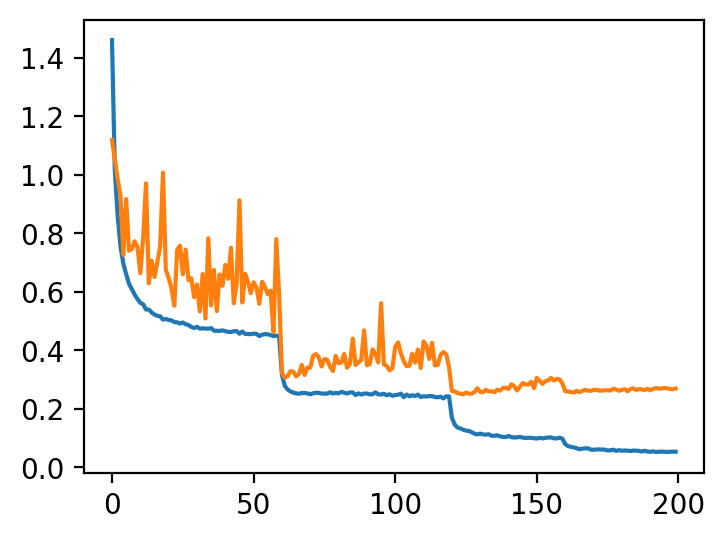

In [25]:
plt.figure(figsize=(4, 3), dpi=200)
plt.plot(training_logs['train_loss'])
plt.plot(training_logs['valid_loss'])

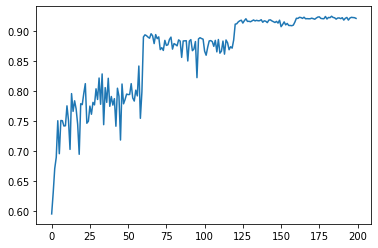

In [26]:
plt.plot(training_logs['accuracy'])

In [27]:
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

In [28]:
torch.save(model.state_dict(), "./last_model_wrn16-1.pt")

In [29]:
model.load_state_dict(torch.load("./best_model_wrn16-1.pt"))

<All keys matched successfully>

In [30]:
preds = []
valid_labels = []

model.eval()
for step, (images, labels) in tqdm(enumerate(test_loader), total = len(test_loader)):

    images = images.to(device, dtype=torch.float)
    labels = labels.to(device)
    batch_size = labels.size(0)

    with torch.no_grad():
        logits, features = model(images)
        
    preds.append(logits[0].softmax(1).to('cpu').numpy())
    valid_labels.append(labels.to('cpu').numpy())

predictions = np.concatenate(preds)
valid_labels = np.concatenate(valid_labels)

score = get_score(valid_labels, predictions.argmax(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.48it/s]


In [31]:
LOGGER.info(f"Test Accuracy: {score:.4f}")

Test Accuracy: 0.9151


In [32]:
LOGGER.info("====================================================")
LOGGER.info(training_logs)

{'train_loss': [1.4603709660424127, 1.0136371316168042, 0.8590230514102511, 0.7555688737763299, 0.6961523152775234, 0.6603286766688029, 0.627522020371755, 0.6093545504675971, 0.5905324965582953, 0.5753065803527831, 0.5622498449431526, 0.5575500297758315, 0.5394604034953647, 0.5394661703745524, 0.5292831847508749, 0.5222794624752468, 0.5180523873858982, 0.5162806933508979, 0.5050119224442376, 0.5070373608006371, 0.5037206754101647, 0.5023860351721445, 0.49644405522876317, 0.4956972067726983, 0.49140721820195515, 0.4950863640361362, 0.4891209210289849, 0.48661317942407395, 0.47975730204052397, 0.47620320733918087, 0.4803048801951938, 0.47408764888445537, 0.47504741974936593, 0.47461063103146023, 0.4737983747164408, 0.4759691737969716, 0.46714857132699755, 0.46661342036989, 0.46625057391060726, 0.46809495708677507, 0.46530061706437004, 0.46289495401382447, 0.4627958182122972, 0.46508784472147624, 0.4655841357337104, 0.4566922509405348, 0.46424435387717355, 0.45610995875464544, 0.455721113